# Source Detection Summary

In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import time

In [2]:
font = {'size' : 15}
mpl.rc('font', **font)

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [4]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [5]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

In [6]:
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [7]:
### If you want to print table schema
# tables = ['exposures','subtractions','objects','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

## Read in the data tables and store as numpy arrays
Note that in some cases specifying the type throws an error, and so type is omitted for some numpy arrays.

In [8]:
t1 = time.time()

query = "SELECT id, filename, mjd, filter FROM exposures"
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

exp_id  = np.asarray( results[0], dtype='int' )
exp_fnm = np.asarray( results[1], dtype='str' )
exp_mjd = np.asarray( results[2], dtype='float' )
exp_fil = np.asarray( results[3], dtype='str' )
del query, results

print(len(exp_id))

0.03995060920715332
4421


In [9]:
t1 = time.time()

query = "SELECT id, lmt_mg, seeing, skysig, magzp, exposure_id FROM subtractions"
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

sub_id     = np.asarray( results[0], dtype='int' )
sub_lmtmg  = np.asarray( results[1], dtype='float' )
sub_seeing = np.asarray( results[2], dtype='float' )
sub_skysig = np.asarray( results[3], dtype='float' )
sub_magzp  = np.asarray( results[4], dtype='float' )
sub_expid  = np.asarray( results[5], dtype='int' )
del query, results

print(len(sub_id))

2.8989923000335693
206066


In [14]:
t1 = time.time()

query = ("SELECT o.id, o.ra, o.dec, o.candidate_id, o.subtraction_id, rbs.rb, o.mag, o.magerr, o.ignore FROM objects o "
         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 ")
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

obj_id     = np.asarray( results[0], dtype='int' )
obj_ra     = np.asarray( results[1], dtype='float' )
obj_dec    = np.asarray( results[2], dtype='float' )
obj_candid = np.asarray( results[3] )
obj_subid  = np.asarray( results[4], dtype='int' )
obj_rb     = np.asarray( results[5], dtype='float' )
obj_mag    = np.asarray( results[6], dtype='float' )
obj_magerr = np.asarray( results[7], dtype='float' )
obj_ignore = np.asarray( results[8] )
del query, results

print(len(obj_id))

69.8312656879425
3237353


In [15]:
### What is this obj_ignore array?
# ix = np.where( obj_ignore == True )[0]
# print(len(ix))

In [16]:
t1 = time.time()

query = "SELECT id, ra, dec, nmatches FROM candidates"
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

cand_id       = np.asarray( results[0] )
cand_ra       = np.asarray( results[1], dtype='float' )
cand_dec      = np.asarray( results[2], dtype='float' )
cand_nmatches = np.asarray( results[3] )
del query, results

print(len(cand_id))

19.716028928756714
1671105


In [17]:
### There are more cand_id than there are unique obj_candid values.
print(len(np.unique(cand_id)))
print(len(np.unique(obj_candid)))

1671105
1077288


### What is cand_nmatches??

It appears to be empty.

In [18]:
# print(cand_nmatches)
# print(len(cand_nmatches))
# cx = np.where( cand_nmatches != None )[0]
# print(len(cx))
# print(cand_nmatches[cx])

#### No matter, we can easily get the number of unique candidate ids from the object array

In [19]:
#all 
values, indices, counts = np.unique( obj_candid, return_inverse = True, return_counts = True )
print( len(values), len(indices), len(counts) )
print( values )
print( indices )
print( counts )
print( np.min(counts), np.max(counts) )

#good "likely-real"
gx = np.where( obj_rb > 0.6 )[0]
gvalues, gindices, gcounts = np.unique( obj_candid[gx], return_inverse = True, return_counts = True )
print( len(gvalues), len(gindices), len(gcounts) )
print( gvalues )
print( gindices )
print( gcounts )
print( np.min(gcounts), np.max(gcounts) )

1077288 3237353 1077288
['DC21b' 'DC21ba' 'DC21baa' ... 'DC21zzx' 'DC21zzy' 'DC21zzz']
[ 886057  837592  886028 ... 1020392  929002  573836]
[163 143  60 ...  81  20   1]
1 762
129363 300058 129363
['DC21b' 'DC21ba' 'DC21baaa' ... 'DC21zzr' 'DC21zzv' 'DC21zzx']
[ 93120  87190  93067 ...  35661 127363 104537]
[ 1  1 21 ...  1  4  1]
1 482


In [20]:
# ### Plot a histogram of the number of candidates with N objects
# plt.figure(figsize=(12, 4))
# plt.hist( counts, bins=100, log=True )
# plt.xlabel('number of objects')
# plt.ylabel('log(number of candidates)')
# plt.show()

In [21]:
# ### Plot a histogram of the number of candidates with N good objects
# plt.figure(figsize=(12, 4))
# plt.hist( gcounts, bins=100, log=True, color='darkorange' )
# plt.xlabel('number of good objects')
# plt.ylabel('log(number of candidates)')
# plt.show()

#### And then make new array to hold the number of objects for a candidate

In [22]:
### The number of objects associated with the same candidate, for each object
obj_nobj = counts[indices]
print(obj_nobj)

[  1   4   1 ... 332   3 188]


#### And also a new cand_nmatches, and one for just "good" objects too

In [23]:
### Get rid of the useless cand_nmatches and repopulate it

t1 = time.time()

del cand_nmatches
cand_nmatches = np.zeros( len(cand_id), dtype='int' )
cand_ngmatches = np.zeros( len(cand_id), dtype='int' )
sx = np.argsort( cand_id )

### Using sorted lists is the only way to do this is a reasonable amount of time
### This is a loop for every unique candidate id
cntr = 0
for c,val in enumerate( values ):
    if (c==100) | (c==1000) | (c==10000):
        print( 'c = ', c, np.round(time.time()-t1,3), 's elapsed' )

    match = False
    while match == False:
        if val == cand_id[sx[cntr]]:
            cand_nmatches[sx[cntr]] = counts[c]
            cntr += 1
            match = True
        else:
            cntr += 1

            
cntr = 0
for c,gval in enumerate( gvalues ):
    if (c==100) | (c==1000) | (c==10000):
        print( 'c = ', c, np.round(time.time()-t1,3), 's elapsed' )

    match = False
    while match == False:
        if gval == cand_id[sx[cntr]]:
            cand_ngmatches[sx[cntr]] = gcounts[c]
            cntr += 1
            match = True
        else:
            cntr += 1

t2 = time.time()
print(t2-t1)
del t1,t2

c =  100 2.187 s elapsed
c =  1000 2.201 s elapsed
c =  10000 2.245 s elapsed
c =  100 4.113 s elapsed
c =  1000 4.132 s elapsed
c =  10000 4.346 s elapsed
5.042417049407959


In [24]:
### Just double check that values of cand_nmatches are as expected (similar to counts array)
# print( cand_nmatches )
# print( np.min(cand_nmatches), np.max(cand_nmatches) )
# for n in [10,20,30,100]:
#     print(n, len(np.where( cand_nmatches >= n )[0]) )

In [25]:
# print( cand_ngmatches )
# print( np.min(cand_ngmatches), np.max(cand_ngmatches) )
# for n in [10,20,30,100]:
#     print(n, len(np.where( cand_ngmatches >= n )[0]) )

In [26]:
### Plot a histogram of the number of candidates with N objects
# plt.figure(figsize=(12, 4))
# plt.hist( cand_nmatches, bins=100, log=True )
# plt.xlabel('number of objects')
# plt.ylabel('log(number of candidates)')
# plt.show()

In [27]:
del values, indices, counts

### Flag objects that are duplicates
They are within 0.1" of another object in the same subtraction.<br>
This takes about 600 seconds.

In [28]:
t1 = time.time()

obj_dup = np.zeros( len(obj_id), dtype='int' )

limit = (0.1 / 3600.0)**2
for s,subid in enumerate(sub_id):
    if (s==100) | (s==1000) | (s==10000) | (s==30000) | (s==60000):
        ix = np.where( obj_dup == 1 )[0]
        print( 's = ', s, np.round(time.time()-t1,3), 's elapsed, ', len(ix),' duplicates identified' )
        del ix
    # all the objects in this subtraction
    ox = np.where( (obj_subid == subid) & (obj_dup == 0) )[0]
    for o in ox:
        # all the objects in this subtraction with similar RA and Dec to the o'th in ox
        tx = np.where( (obj_ra[ox]-obj_ra[o])**2 + (obj_dec[ox]-obj_dec[o])**2 < limit )[0]
        if len(tx) > 0:
            # identify all the matching objects as duplicates
            obj_dup[ox[tx]] = 1
            # except the first one, of course, consider it the 'real' one
            obj_dup[o] = 0
        del tx
    del ox

tx = np.where( obj_dup == 1 )[0]
print('total number of duplicates identified: ',len(tx))
del tx

t2 = time.time()
print(t2-t1)
del t1,t2

s =  100 0.744 s elapsed,  265  duplicates identified
s =  1000 7.027 s elapsed,  3652  duplicates identified
s =  10000 68.232 s elapsed,  13884  duplicates identified
s =  30000 202.412 s elapsed,  56043  duplicates identified
s =  60000 400.881 s elapsed,  93518  duplicates identified
total number of duplicates identified:  104109
1351.8554937839508


### Flag objects that are from "bad" (short-exposure) images
(i.e., files that do not have a classification of COSMOS, COSMOS-AGN, or ELAIS)

At the same time, get the filter for each object.

In [29]:
temp = []
for efnm in exp_fnm:
    temp.append( efnm[0:21] )
exp_fnmbase = np.asarray( temp, dtype='str' )
print( exp_fnm[0], exp_fnmbase[0] )

c4d_210917_020357_ori.fits.fz c4d_210917_020357_ori


In [30]:
t1 = time.time()

obj_bimg = np.zeros( len(obj_id), dtype='int' )
obj_filt = np.zeros( len(obj_id), dtype='str' )
obj_mjd  = np.zeros( len(obj_id), dtype='float' )

img_fnmbase = np.loadtxt( 'archive_image_list.txt', dtype='str', usecols=(0) )
img_class   = np.loadtxt( 'archive_image_list.txt', dtype='str', usecols=(9) )

for f,fnmbase in enumerate(img_fnmbase):
    if (f==10) | (f==100) | (f==1000):
        ix = np.where( obj_bimg == 1 )[0]
        print( 'f = ', f, np.round(time.time()-t1,3), 's elapsed, ', len(ix),' objects in bad images identified' )
        del ix
    if (img_class[f] != 'COSMOS') & (img_class[f] != 'COSMOS-AGN') & (img_class[f] != 'ELAIS'):
        # all the exposures associated with this filename
        ex = np.where( exp_fnmbase == fnmbase )[0]
        if len(ex) > 0:
            for e in ex:
                # all the subtractions associated with this exposure
                sx = np.where( sub_expid == exp_id[e] )[0]
                if len(sx) > 0:
                    for s in sx:
                        # all the objects associated with this subtraction
                        ox = np.where( obj_subid == sub_id[s] )[0]
                        if len(ox) > 0:
                            obj_bimg[ox] = 1
                        del ox
                del sx
        del ex
    else:
        # all the exposures associated with this filename
        ex = np.where( exp_fnmbase == fnmbase )[0]
        if len(ex) > 0:
            for e in ex:
                sx = np.where( sub_expid == exp_id[e] )[0]
                if len(sx) > 0:
                    for s in sx:
                        # all the objects associated with this subtraction
                        ox = np.where( obj_subid == sub_id[s] )[0]
                        if len(ox) > 0:
                            obj_filt[ox] = exp_fil[e]
                            obj_mjd[ox] = exp_mjd[e]
                        del ox
                del sx
        del ex

tx = np.where( obj_bimg == 1 )[0]
print('number of objects in bad images = ', len(tx) )
del tx

t2 = time.time()
print(t2-t1)
del t1,t2

f =  10 0.932 s elapsed,  0  objects in bad images identified
f =  100 9.64 s elapsed,  3948  objects in bad images identified
f =  1000 88.439 s elapsed,  44362  objects in bad images identified
number of objects in bad images =  96354
197.49016785621643


In [31]:
### Just make sure the values of obj_filt are as expected
tx = np.where( obj_bimg == 0 )[0]
print( obj_filt[tx] )
print( np.unique( obj_filt[tx] ) )
del tx

['' '' '' ... 'r' 'g' 'g']
['' 'g' 'i' 'r']


### Generate some features of candidates (with >10 good matches) light curves.

Candidate light curve time span (tspan), amplitude (amp) and mean R/B score. Only for objects (detections) with R/B>0.6.

The following takes about 4 minutes.

In [32]:
t1 = time.time()

### Candidate LC timespan and amplitude
###  dimension 0,1,2,3 are for all filters, g, r, and i
cand_LCtspan = np.zeros( (len(cand_nmatches),4), dtype='float' )
cand_LCamp   = np.zeros( (len(cand_nmatches),4), dtype='float' )
cand_LCngdet = np.zeros( (len(cand_nmatches),4), dtype='int' )
cand_meanrb  = np.zeros( (len(cand_nmatches),4), dtype='float' )

cx = np.where( cand_ngmatches >=10 )[0]
print('len(cx) = ', len(cx) )

for i,c in enumerate(cx):
    if (i==100) | (i==1000) | (i==10000):
        print( 'i = ', i, 'c = ', c, np.round(time.time()-t1,3), 's elapsed' )

    ### All non-bad_img, non-duplicate, likely-real objects associated with this candidate
    ox = np.where( (obj_candid == cand_id[c]) & (obj_bimg == 0) & (obj_dup == 0) & (obj_rb > 0.6) )[0]
    if len(ox) >= 10:
        cand_LCtspan[c,0] = np.max(obj_mjd[ox]) - np.min(obj_mjd[ox])
        cand_LCamp[c,0]   = np.max(obj_mag[ox]) - np.min(obj_mag[ox])
        cand_LCngdet[c,0] = len(ox)
        cand_meanrb[c,0]  = np.mean(obj_rb[ox])
        for f,fil in enumerate(['g','r','i']):
            fx = np.where( obj_filt[ox] == fil )[0]
            if len(fx) > 1:
                cand_LCtspan[c,f+1] = np.max(obj_mjd[ox[fx]]) - np.min(obj_mjd[ox[fx]])
                cand_LCamp[c,f+1]   = np.max(obj_mag[ox[fx]]) - np.min(obj_mag[ox[fx]])
                cand_LCngdet[c,f+1] = len(fx)
                cand_meanrb[c,f+1]  = np.mean(obj_rb[ox[fx]])
            del fx
    del ox

print( 'finished. ', np.round(time.time()-t1,3), 's elapsed' )
del t1,cx

len(cx) =  2774
i =  100 c =  14055 20.664 s elapsed
i =  1000 c =  150860 192.428 s elapsed
finished.  535.899 s elapsed


<br><br>

## Plots for ALL the objects 
Except those in "bad" images, or objects which are duplicates

In [33]:
c = ['darkgreen', 'red', 'brown', 'limegreen', 'darkorange', 'peru']

In [34]:
cx = np.where( (obj_bimg == 0) & (obj_dup == 0) & (obj_ra > 145.0) & (obj_ra < 155.0) & (obj_dec > -3.0) & (obj_dec < 7.0) )[0]
ex = np.where( (obj_bimg == 0) & (obj_dup == 0) & (obj_ra > 3.0) & (obj_ra < 13.0) & (obj_dec > -48.0) & (obj_dec < -38.0) )[0]
print(len(cx),len(ex))

1602456 660151


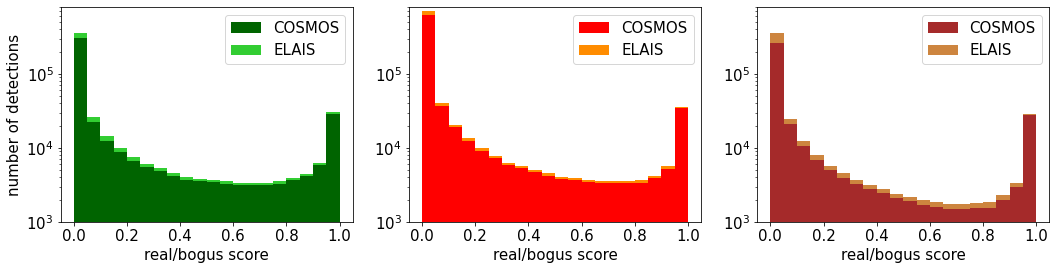

In [35]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[cx] == ifilt )[0]
    fex = np.where( obj_filt[ex] == ifilt )[0]
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [obj_rb[cx[fcx]],obj_rb[ex[fex]]], bins=20, stacked=True, log=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
    ax[i].legend()
    if i == 0:
        ax[i].set_ylabel("number of detections")
    ax[i].set_xlabel("real/bogus score")
    ax[i].set_ylim([1e3,8e5])
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/rbhist.png")

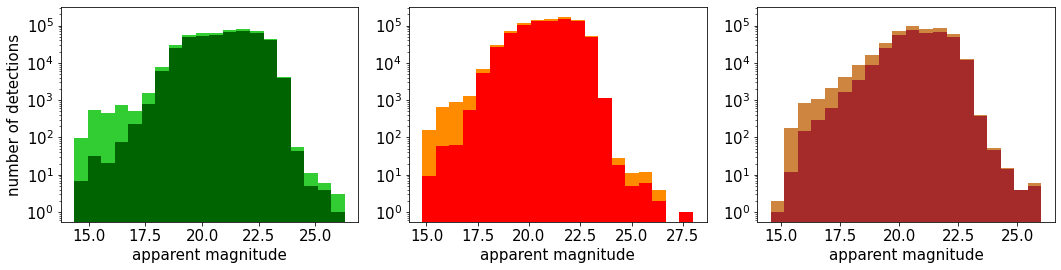

In [36]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[cx] == ifilt )[0]
    fex = np.where( obj_filt[ex] == ifilt )[0]
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [obj_mag[cx[fcx]],obj_mag[ex[fex]]], bins=20, stacked=True, log=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
#     ax[i].legend()
    if i == 0:
        ax[i].set_ylabel("number of detections")
    ax[i].set_xlabel("apparent magnitude")
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/maghist.png")

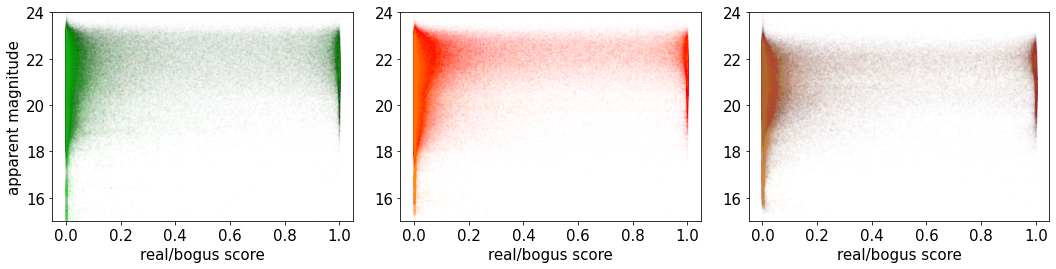

In [37]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[cx] == ifilt )[0]
    fex = np.where( obj_filt[ex] == ifilt )[0]
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].plot( obj_rb[cx[fcx]], obj_mag[cx[fcx]], 'o',ms=2,alpha=0.01,mew=0, color=c[i], label='COSMOS' )
    ax[i].plot( obj_rb[ex[fex]], obj_mag[ex[fex]], 'o',ms=2,alpha=0.03,mew=0, color=c[i+3], label='ELAIS' )
    if i == 0:
        ax[i].set_ylabel("apparent magnitude")
    ax[i].set_xlabel("real/bogus score")
    ax[i].set_ylim([15.0,24.0])
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/magVrb.png")

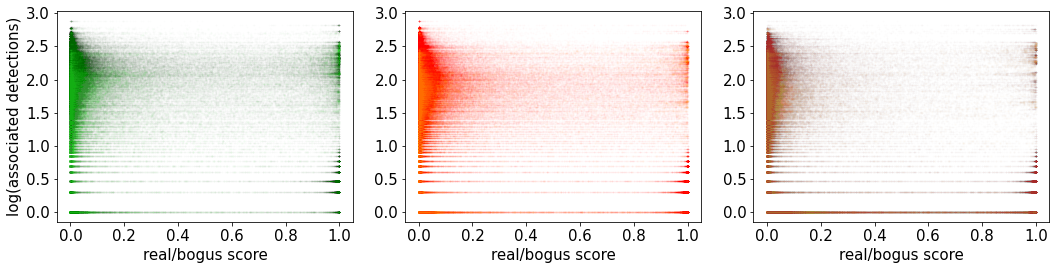

In [38]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[cx] == ifilt )[0]
    fex = np.where( obj_filt[ex] == ifilt )[0]
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].plot( obj_rb[cx[fcx]], np.log10(obj_nobj[cx[fcx]]), 'o',ms=2,alpha=0.01,mew=0, color=c[i], label='COSMOS' )
    ax[i].plot( obj_rb[ex[fex]], np.log10(obj_nobj[ex[fex]]), 'o',ms=2,alpha=0.03,mew=0, color=c[i+3], label='ELAIS' )
    if i == 0:
        ax[i].set_ylabel("log(associated detections)")
    ax[i].set_xlabel("real/bogus score")
#     ax[i].set_ylim([15.0,24.0])
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/nobjVrb.png")

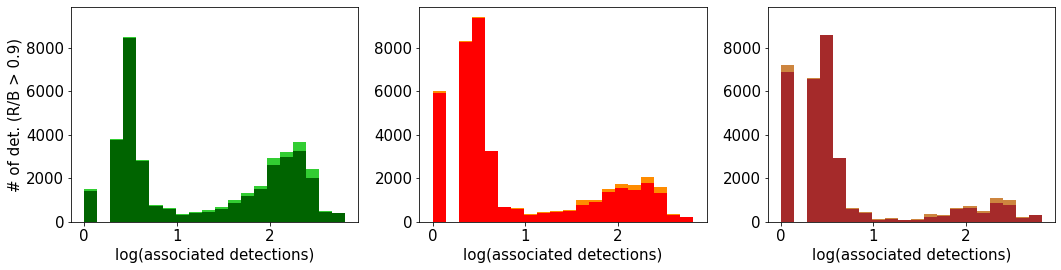

In [39]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( (obj_filt[cx] == ifilt) & (obj_rb[cx] > 0.9) )[0]
    fex = np.where( (obj_filt[ex] == ifilt) & (obj_rb[ex] > 0.9) )[0]
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [np.log10(obj_nobj[cx[fcx]]),np.log10(obj_nobj[ex[fex]])], bins=20, \
               stacked=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'] )
    if i == 0:
        ax[i].set_ylabel("# of det. (R/B > 0.9)")
    ax[i].set_xlabel("log(associated detections)")
#     ax[i].set_ylim([15.0,24.0])
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/nobjcutoff.png")

<br><br>

## Plots for Objects that are likely real (R/B>0.6) and potentially astrophysical (>10 detections of any R/B value).

In [40]:
good_cx = np.where( (obj_nobj > 10) & (obj_rb >= 0.6) & (obj_bimg == 0) & (obj_dup == 0) & \
                   (obj_ra > 145.0) & (obj_ra < 155.0) & (obj_dec > -3.0) & (obj_dec < 7.0) )[0]
good_ex = np.where( (obj_nobj > 10) & (obj_rb >= 0.6) & (obj_bimg == 0) & (obj_dup == 0) & \
                   (obj_ra > 3.0) & (obj_ra < 13.0) & (obj_dec > -48.0) & (obj_dec < -38.0) )[0]

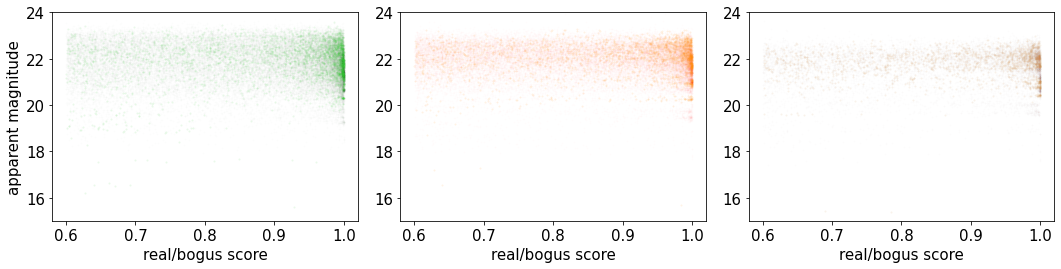

In [41]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[good_cx] == ifilt )
    fex = np.where( obj_filt[good_ex] == ifilt )
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].plot( obj_rb[good_cx[fcx]], obj_mag[good_cx[fcx]], 'o',ms=2,alpha=0.01,mew=0, color=c[i], label='COSMOS' )
    ax[i].plot( obj_rb[good_ex[fex]], obj_mag[good_ex[fex]], 'o',ms=2,alpha=0.1,mew=0, color=c[i+3], label='ELAIS' )
    if i == 0:
        ax[i].set_ylabel("apparent magnitude")
    ax[i].set_xlabel("real/bogus score")
    ax[i].set_ylim([15.0,24.0])
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/magVrb_good.png")

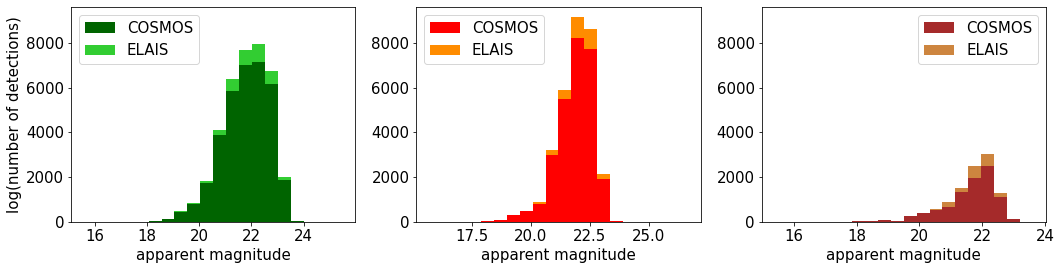

In [42]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[good_cx] == ifilt )
    fex = np.where( obj_filt[good_ex] == ifilt )
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [obj_mag[good_cx[fcx]],obj_mag[good_ex[fex]]], bins=20, stacked=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
    ax[i].legend()
    if i == 0:
        ax[i].set_ylabel("log(number of detections)")
    ax[i].set_xlabel("apparent magnitude")
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/maghist_good.png")

59377


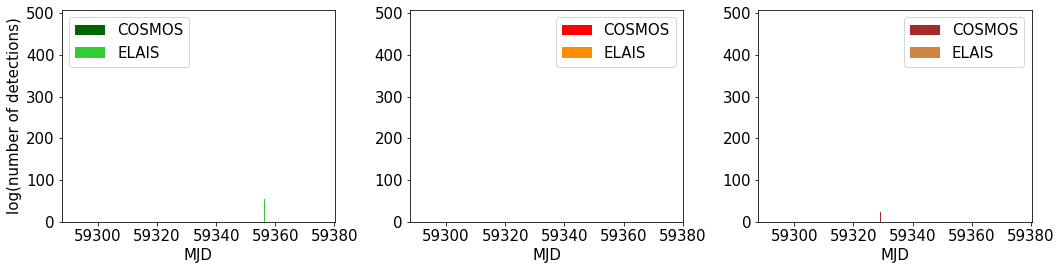

In [43]:
nbins = int(np.ceil( np.max(obj_mjd[good_cx]) - np.min(obj_mjd[good_cx]) ))
print(nbins)
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[good_cx] == ifilt )
    fex = np.where( obj_filt[good_ex] == ifilt )
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [obj_mjd[good_cx[fcx]],obj_mjd[good_ex[fex]]], bins=nbins, stacked=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
    ax[i].legend()
    ax[i].set_xlabel("MJD")
    if i == 0:
        ax[i].set_ylabel("log(number of detections)")
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/maghist_good.png")

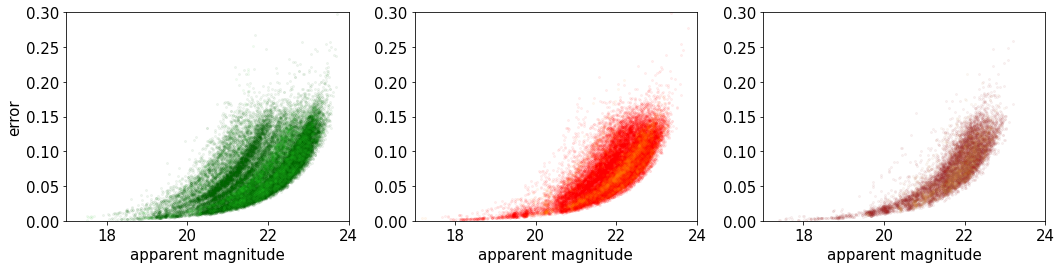

In [44]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( obj_filt[good_cx] == ifilt )
    fex = np.where( obj_filt[good_ex] == ifilt )
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].plot( obj_mag[good_cx[fcx]],obj_magerr[good_cx[fcx]], 'o',ms=2,alpha=0.05, color=c[i])
    ax[i].plot( obj_mag[good_ex[fex]],obj_magerr[good_ex[fex]], 'o',ms=2,alpha=0.05, color=c[i+3])
#     ax[i].legend()
    if i == 0:
        ax[i].set_ylabel("error")
    ax[i].set_xlabel("apparent magnitude")
    ax[i].set_xlim([17,24])
    ax[i].set_ylim([0.0,0.3])
    del fcx,fex
fig.tight_layout()
plt.savefig("./source_detection_summary_figures/magerr_good.png")

## Plots for Candidates that are likely supernovae

They had >10 good (R/B>0.6) detections overall. Then we impose >10 good (R/B>0.6) in each filter as well, for the plots.

In [45]:
cx = np.where( cand_ngmatches >=10 )[0]

Plot the amplitude vs. the time span. Notice how setting amplitude>0.6 mag and timespan 15-70 days cuts out a lot of points that are clustered in the timespan axis. Setting a timepan limit of 80 days also rejects candidates that had simply changed from the time of the template image but did not vary during our survey time (like AGN, which is a real astrophysical transient but not a SN).

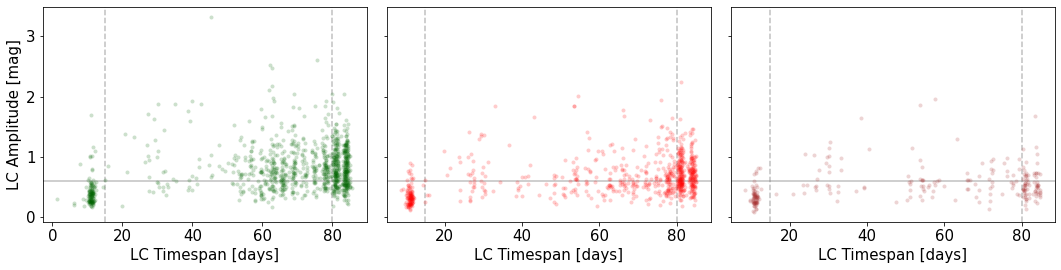

In [46]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    ax[i].axhline(0.6, alpha=0.5,color='grey')
    ax[i].axvline(15, alpha=0.5,color='grey',ls='dashed')
    ax[i].axvline(80, alpha=0.5,color='grey',ls='dashed')
    fx = np.where( cand_LCngdet[cx,i+1] >= 10 )[0]
    randos = np.random.normal( size=len(fx) ) * 0.5
    ax[i].plot( cand_LCtspan[cx[fx],i+1]+randos, cand_LCamp[cx[fx],i+1], 'o',ms=4,mew=0,alpha=0.2, color=c[i] )
    del fx
    if i == 0:
        ax[i].set_ylabel("LC Amplitude [mag]")
    ax[i].set_xlabel("LC Timespan [days]")
fig.tight_layout()

Plot the mean R/B score for all associated detections with R/B>0.6. There aren't really any usable correlations here with mean R/B value that we could use.

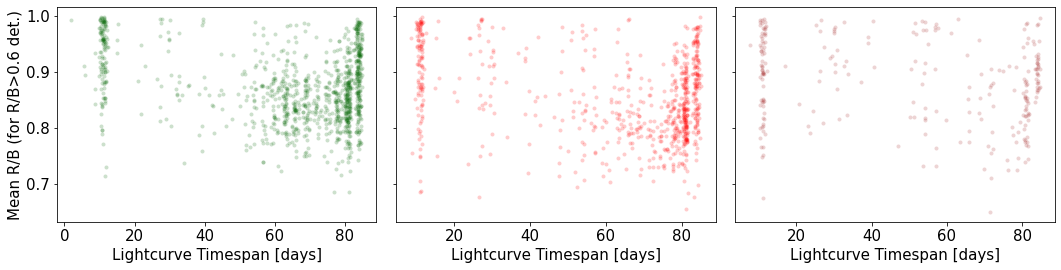

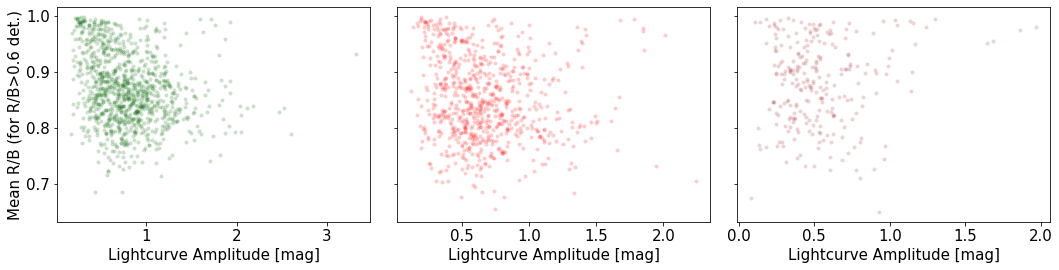

In [47]:
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( cand_LCngdet[cx,i+1] >= 10 )[0]
    randos = np.random.normal( size=len(fx) ) * 0.5
    ax[i].plot( cand_LCtspan[cx[fx],i+1]+randos, cand_meanrb[cx[fx],i+1], 'o',ms=4,mew=0,alpha=0.2, color=c[i] )
    del fx
    ax[i].set_xlabel("Lightcurve Timespan [days]")
    if i == 0:
        ax[i].set_ylabel("Mean R/B (for R/B>0.6 det.)")
fig.tight_layout()

fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( cand_LCngdet[cx,i+1] >= 10 )[0]
    ax[i].plot( cand_LCamp[cx[fx],i+1], cand_meanrb[cx[fx],i+1], 'o',ms=4,mew=0,alpha=0.2, color=c[i] )
    del fx
    ax[i].set_xlabel("Lightcurve Amplitude [mag]")
    if i == 0:
        ax[i].set_ylabel("Mean R/B (for R/B>0.6 det.)")
fig.tight_layout()

#### There is some odd clustering of candidates in RA and Dec.

 0 < timespan < 15 days
 15 < timespan < 80 days 
 80 < timespan 


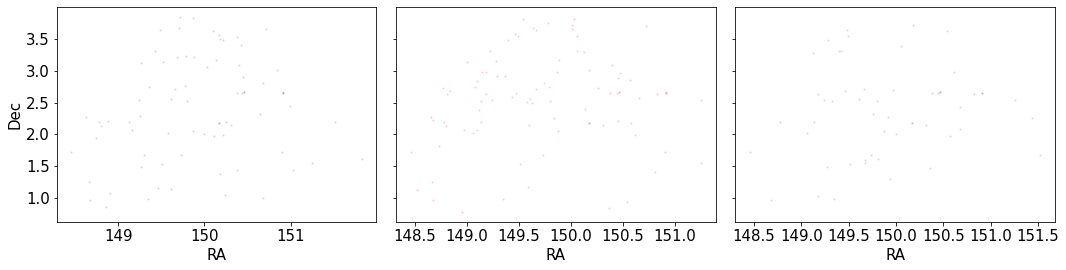

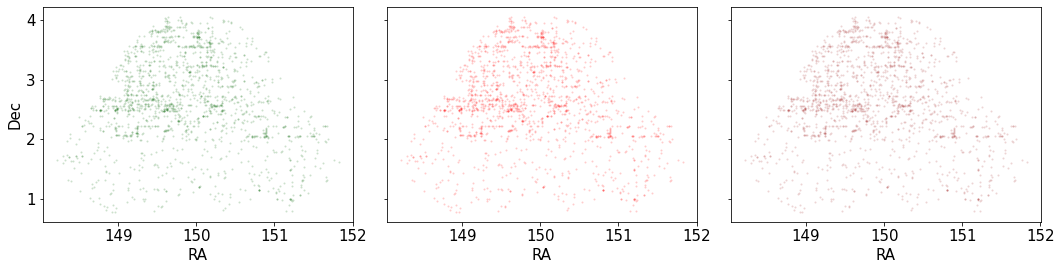

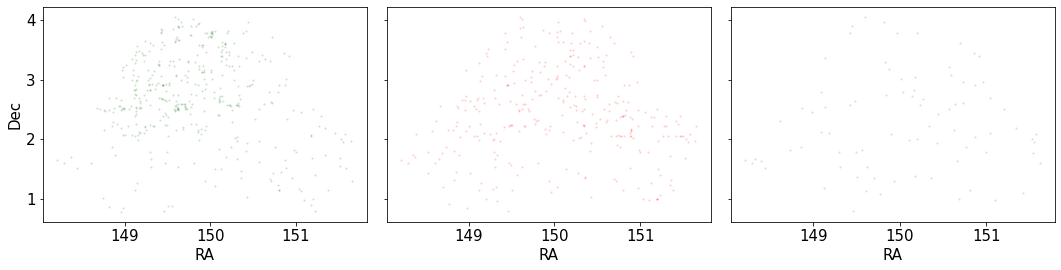

In [48]:
cx = np.where( (cand_ngmatches >=10) & \
              (cand_ra > 145.0) & (cand_ra < 155.0) & (cand_dec > -3.0) & (cand_dec < 7.0) )[0]
ex = np.where( (cand_ngmatches >=10) & \
              (cand_ra > 3.0) & (cand_ra < 13.0) & (cand_dec > -48.0) & (cand_dec < -38.0) )[0]

print(' 0 < timespan < 15 days')
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( (cand_LCtspan[cx,i+1] > 0.0) & (cand_LCtspan[cx,i+1] < 15.0) )[0]
    ax[i].plot( cand_ra[cx[fx]], cand_dec[cx[fx]], 'o',ms=2,mew=0,alpha=0.2, color=c[i] )
    ax[i].set_xlabel("RA")
    if i == 0:
        ax[i].set_ylabel("Dec")
fig.tight_layout()

print(' 15 < timespan < 80 days ')
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( (cand_LCtspan[cx,i+1] >= 15.0) | (cand_LCtspan[cx,i+1] <= 80.0) )[0]
    ax[i].plot( cand_ra[cx[fx]], cand_dec[cx[fx]], 'o',ms=2,mew=0,alpha=0.2, color=c[i] )
    ax[i].set_xlabel("RA")
    if i == 0:
        ax[i].set_ylabel("Dec")
fig.tight_layout()

print(' 80 < timespan ')
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( cand_LCtspan[cx,i+1] > 80.0 )[0]
    ax[i].plot( cand_ra[cx[fx]], cand_dec[cx[fx]], 'o',ms=2,mew=0,alpha=0.2, color=c[i] )
    ax[i].set_xlabel("RA")
    if i == 0:
        ax[i].set_ylabel("Dec")
fig.tight_layout()

 mean R/B < 0.9 
 mean R/B >= 0.9 


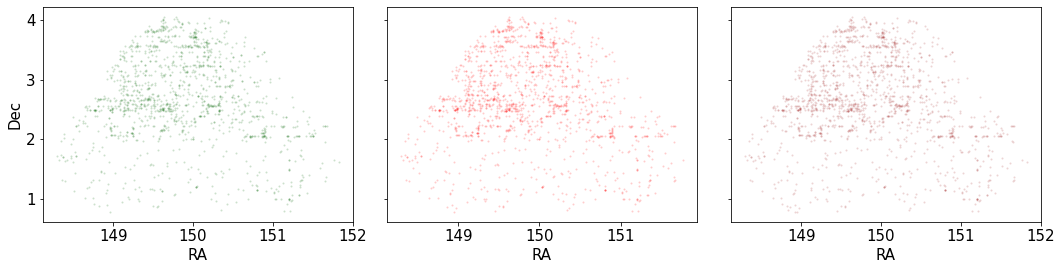

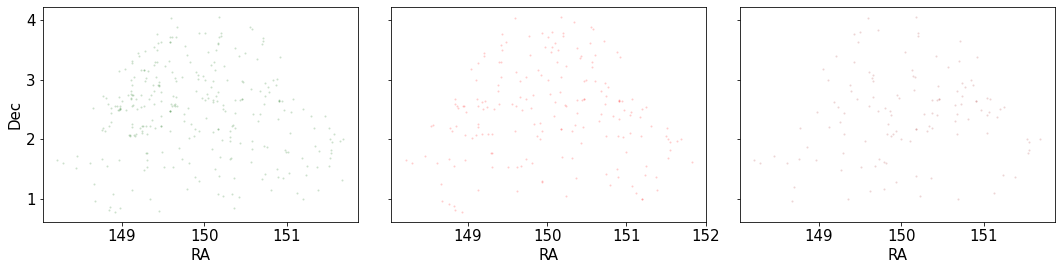

In [49]:
print(' mean R/B < 0.9 ')
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( cand_meanrb[cx,i+1] < 0.9 )[0]
    ax[i].plot( cand_ra[cx[fx]], cand_dec[cx[fx]], 'o',ms=2,mew=0,alpha=0.2, color=c[i] )
    ax[i].set_xlabel("RA")
    if i == 0:
        ax[i].set_ylabel("Dec")
fig.tight_layout()

print(' mean R/B >= 0.9 ')
fig, ax = plt.subplots( 1, 3, figsize=(15,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fx = np.where( cand_meanrb[cx,i+1] >= 0.9 )[0]
    ax[i].plot( cand_ra[cx[fx]], cand_dec[cx[fx]], 'o',ms=2,mew=0,alpha=0.2, color=c[i] )
    ax[i].set_xlabel("RA")
    if i == 0:
        ax[i].set_ylabel("Dec")
fig.tight_layout()